# ValueInvestor
We are looking to establish a robust intelligent system that can aid investment activities, using past stock performance data. 

Our goal in this project is to use provided historical trading data to predict future stock price valuations on a daily, weekly, and monthly basis. We also provide recommendations on whether to BUY, HOLD or SELL each stock based on the predictions.

### Data Description


We are given trading data from 8 different countries in emerging markets that include the 2020 Q1-Q2-Q3-Q4 and 2021 Q1 stock prices. Each market's operating days varies based on the country of the company and the market the stocks are exchanged. We will only 2020 data and predict with 2021 Q1 data.

Each set of data contain the following columns:
- `Date`
- `Price` (The closing price of the stock on a day)
- `Open` (The opening price of the stock on a day)
- `High` (The highest price of the stock on a day)
- `Low` (The lowest price of the stock on a day)
- `Vol.` (The volume/number of shares that were traded on a day)
- `Change %` (The percentage change from the closing price of the previous day)

### Data Loading
Let's first load the data of the first sheet.

In [469]:
# Import the necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose

In [470]:
df = pd.read_excel("2020Q1Q2Q3Q4-2021Q1.xlsx", sheet_name=None)

In [471]:
print(df.keys())

dict_keys(['Russia - Sberbank Rossii PAO (S', 'Turkey - Koc Holding AS (KCHOL)', 'Egypt - Medinet Nasr Housing (M', 'Brazil - Minerva SABrazil (BEEF', 'Argentina - Pampa Energia SA (P', 'Colombia - Cementos Argos SA (C', 'South Africa - Impala Platinum ', 'South Korea - Dongkuk Steel Mil'])


In [472]:
sheet1 = df[list(df.keys())[0]] # Extract the first shee
sheet1 = sheet1.iloc[:-1,:] # Drop the last row
sheet1["Price"].describe(percentiles=[0.25, 0.5, 0.75])

count     311.0
unique    303.0
top       272.0
freq        2.0
Name: Price, dtype: float64

In [473]:
sheet1["Price"].astype(float).describe()

count    311.000000
mean     234.524019
std       32.079847
min      174.270000
25%      207.700000
50%      229.140000
75%      264.380000
max      293.300000
Name: Price, dtype: float64

In [474]:
sheet1["Change %"].describe()

count    311.000000
mean       0.000668
std        0.021931
min       -0.095700
25%       -0.010100
50%        0.000400
75%        0.012950
max        0.129000
Name: Change %, dtype: float64

### Data Exploration

#### Check for missing values

In [475]:
sheet1.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

#### Check for outliers

In [476]:
fig = px.box(sheet1, x="Price")
fig.show()

In [477]:
fig = px.box(sheet1, x="Open")
fig.show()

In [478]:
fig = px.box(sheet1, x="High")
fig.show()

In [479]:
fig = px.box(sheet1, x="Low")
fig.show()

In [480]:
sheet1['Vol.'].str[:-1].astype(float)

0      47.00
1      38.81
2      43.68
3      56.07
4      35.22
       ...  
306    18.85
307    38.33
308    40.82
309    22.35
310    35.85
Name: Vol., Length: 311, dtype: float64

In [481]:
sheet1['Vol.'] = sheet1['Vol.'].str[:-1].astype(float)
fig = px.box(sheet1, x='Vol.')
fig.show()

/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_76149/3553842436.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [482]:
sheet1['Vol.'].describe()

count    311.000000
mean      73.056977
std       38.058095
min        8.760000
25%       47.670000
50%       66.260000
75%       85.120000
max      263.040000
Name: Vol., dtype: float64

In [483]:
fig = px.box(sheet1, x="Change %")
fig.show()

In [484]:
sheet1['Change %'].describe()

count    311.000000
mean       0.000668
std        0.021931
min       -0.095700
25%       -0.010100
50%        0.000400
75%        0.012950
max        0.129000
Name: Change %, dtype: float64

Plot the price over time.

In [485]:
# Convert dates to DateTime
sheet1["Datetime"] = pd.to_datetime(sheet1["Date"],format='%Y-%m-%d %H:%M:%S') 

# Set Datetime as the index
sheet1 = sheet1.set_index(pd.DatetimeIndex(sheet1["Datetime"])).sort_index()

/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_76149/3080680778.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [486]:
fig = px.line(sheet1, x='Datetime', y="Price")
fig.show()

### ARIMA (Autoregressive integrated moving average)

#### Check assumptions of the ARIMA model
The following assumptions need to be satisified:
- Data should be stationary
- Data should be univariate

To check that the data is stationary, we can use the ADF (Augmented Dickey-Fuller) Test.

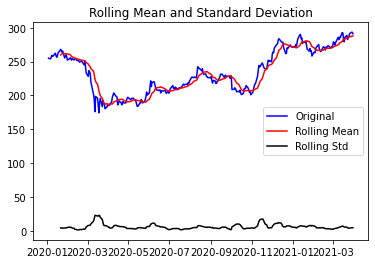

Results of dickey fuller test
Test Statistics                 -0.986360
p-value                          0.758207
No. of lags used                 8.000000
Number of observations used    302.000000
critical value (1%)             -3.452190
critical value (5%)             -2.871158
critical value (10%)            -2.571895
dtype: float64


In [487]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(sheet1.Price)

As the p-value > 0.05, we can't rule out the null hypothesis that a unit root exists in this sample.

<Figure size 432x288 with 0 Axes>

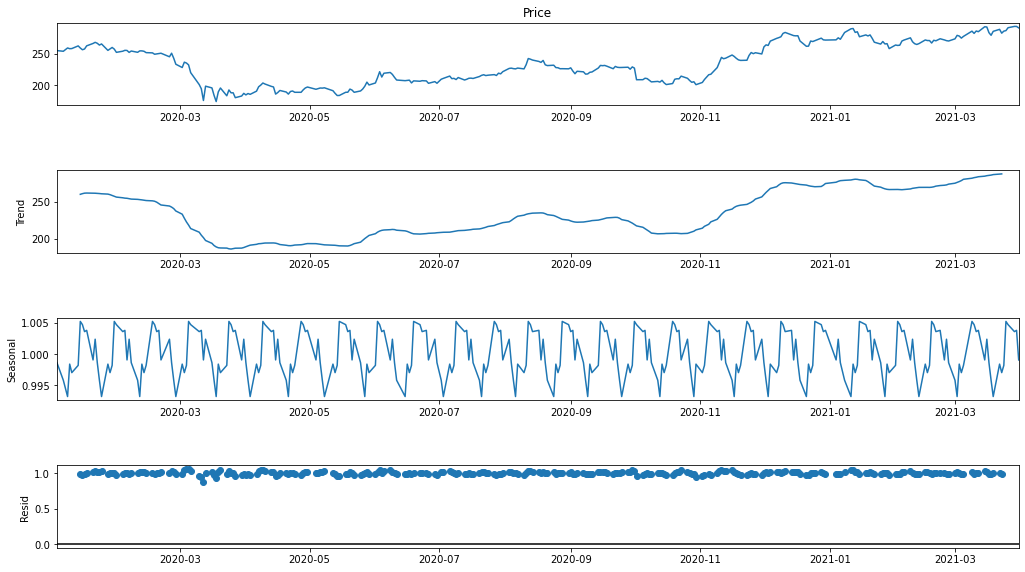

In [488]:
# Separate the trend and the seasonality from a time series
result = seasonal_decompose(sheet1.Price, period=12, model='multiplicative')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

We can try and normalize the seasonality by the difference of log to price and shifted the log value of price to one step.

<AxesSubplot:title={'center':'after log transformed & differencing'}, xlabel='Datetime'>

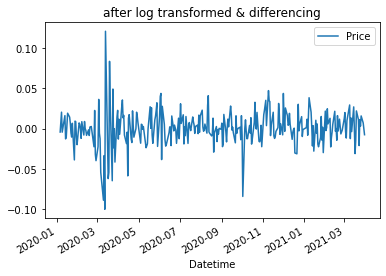

In [489]:
log_prices = pd.DataFrame(sheet1.Price.apply(lambda x : np.log(x)))
log_diff = log_prices - log_prices.shift()
#ax1 = plt.subplot()
log_diff.plot(title='after log transformed & differencing')
#ax2 = plt.subplot()
#sheet1.Price.plot(title='original'); 

Try the test for stationarity again.

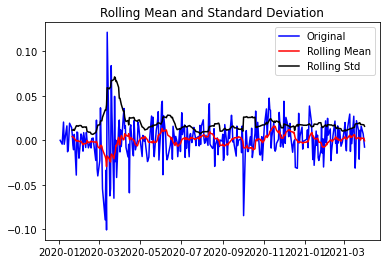

Results of dickey fuller test
Test Statistics               -5.905231e+00
p-value                        2.718502e-07
No. of lags used               7.000000e+00
Number of observations used    3.030000e+02
critical value (1%)           -3.452118e+00
critical value (5%)           -2.871127e+00
critical value (10%)          -2.571878e+00
dtype: float64


In [490]:
test_stationarity(log_diff.fillna(0))

Now the p-value is < 0.05.

Now lets split the data into training and testing data.
- We'll use data from 2020-01-01 to 2020-09-30 for training the model
- We'll use data from 2020-10-01 to 2020-12-31 for testing the model

In [491]:
train_data = log_diff[log_diff.index < datetime.strptime("2020-10-01", "%Y-%m-%d")]
test_data = log_diff[(log_diff.index >= datetime.strptime("2020-10-01", "%Y-%m-%d")) & (log_diff.index < datetime.strptime("2021-01-01", "%Y-%m-%d"))]

In [492]:
train_data = sheet1[sheet1["Datetime"] < datetime.strptime("2020-10-01", "%Y-%m-%d")]
test_data = sheet1[(sheet1["Datetime"] >= datetime.strptime("2020-10-01", "%Y-%m-%d")) & (sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d"))]

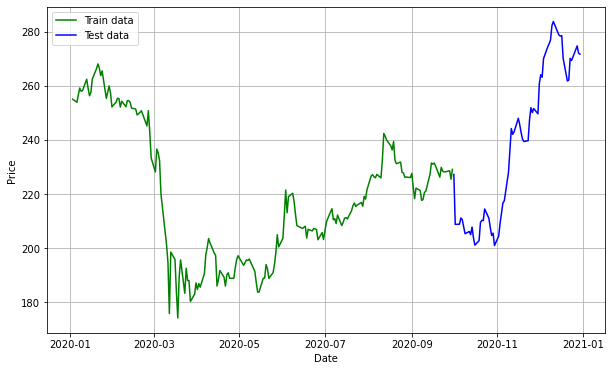

In [493]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(train_data["Datetime"], train_data["Price"], 'green', label='Train data')
plt.plot(test_data["Datetime"], test_data["Price"], 'blue', label='Test data')
plt.legend()

Using Auto ARIMA, we'll now choose the p, d and q values for our model, where:
- `p`: The auto-regressive part
- `d`: The integrated/differencing part - the amount of past time points to subtract from the current value
- `q`: The moving average part

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1066.312, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1065.294, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1064.991, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1066.688, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1066.663, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1066.699, Time=0.05 sec


/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packa

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1068.650, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1064.824, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1066.601, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1066.653, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1065.099, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1068.600, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.407 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  191
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -530.412
Date:                Tue, 22 Nov 2022   AIC                           1064.824
Time:                        14:22:11   BIC                           1071.318
Sample:                             0   HQIC                          1067.455
                                - 191                

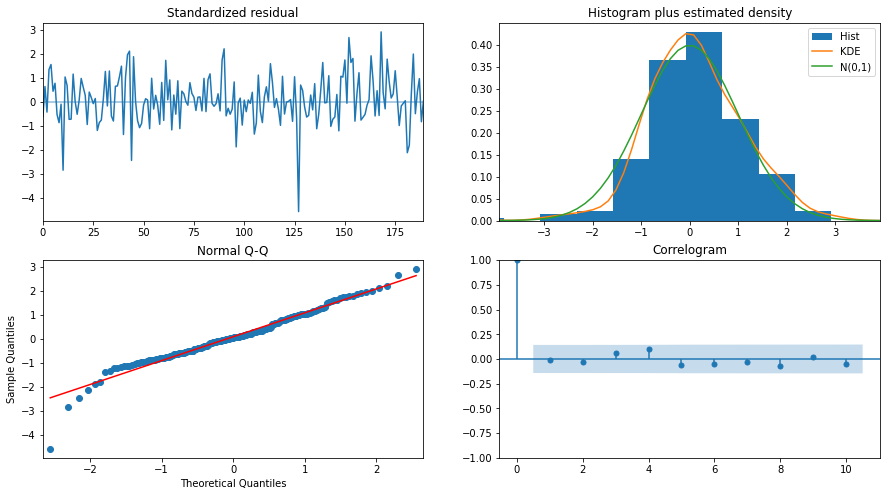

In [494]:
# Use Auto ARIMA to find the best p, d, and q values
model_autoARIMA = auto_arima(temp_data.Price, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

We get the result, `Best model:  ARIMA(0,1,0)(0,0,0)[0]`, therefore the best parameters are p=0, d=1, q=0.

In [495]:
# Change train_data range
train_data = sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")]

In [496]:
# Build Model
#model = ARIMA(train_data.resample("D").last().Price, order=model_autoARIMA.order)
model = ARIMA(train_data.resample("D").last().Price, order=[0,1,0])
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  363
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -756.924
Date:                Tue, 22 Nov 2022   AIC                           1515.847
Time:                        14:22:11   BIC                           1519.739
Sample:                    01-03-2020   HQIC                          1517.394
                         - 12-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        19.9952      0.982     20.368      0.000      18.071      21.919
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1000.99
Prob(Q):                              0.95   Pr

Lets also created models with the following p, d and q values:
- [0,1,1]
- [0,1,2]
- [1,1,1]

In [497]:
model = ARIMA(train_data.resample("D").last().Price, order=[0,1,1])
fitted2 = model.fit()  
print(fitted2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  363
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -755.534
Date:                Tue, 22 Nov 2022   AIC                           1515.067
Time:                        14:22:11   BIC                           1522.851
Sample:                    01-03-2020   HQIC                          1518.162
                         - 12-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1287      0.035     -3.705      0.000      -0.197      -0.061
sigma2        20.5150      1.086     18.883      0.000      18.386      22.644
Ljung-Box (L1) (Q):                   1.85   Jarque-

In [498]:
model = ARIMA(train_data.resample("D").last().Price, order=[0,1,2])
fitted3 = model.fit()  
print(fitted3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  363
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -754.658
Date:                Tue, 22 Nov 2022   AIC                           1515.317
Time:                        14:22:11   BIC                           1526.991
Sample:                    01-03-2020   HQIC                          1519.958
                         - 12-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0706      0.050     -1.409      0.159      -0.169       0.028
ma.L2         -0.0987      0.076     -1.291      0.197      -0.249       0.051
sigma2        20.3015      1.068     19.013      0.0

In [499]:
model = ARIMA(train_data.resample("D").last().Price, order=[1,1,1])
fitted4 = model.fit()  
print(fitted4.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  363
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -755.273
Date:                Tue, 22 Nov 2022   AIC                           1516.545
Time:                        14:22:11   BIC                           1528.220
Sample:                    01-03-2020   HQIC                          1521.186
                         - 12-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2219      0.530      0.419      0.675      -0.816       1.260
ma.L1         -0.3382      0.492     -0.688      0.492      -1.302       0.626
sigma2        20.4892      1.085     18.893      0.0

##### SES (Simple Exponential Smoothing) Model

In [500]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

ses_model = SimpleExpSmoothing(np.asarray(train_data['Price']))

##### HES (Holt's Exponential Smoothing) Model

In [501]:
holt_model = Holt(np.asarray(train_data['Price']))

fit_holt = holt_model.fit(smoothing_level=.3, smoothing_trend=.05)

### Forecast on test dataset

##### ARIMA Model 1

In [502]:
predicted = fitted.get_prediction(start=pd.to_datetime("2020-10-01"), end=pd.to_datetime("2021-03-01"), dynamic=False, full_results=True)
predicted_ci = fitted.conf_int()
#predicted.predicted_mean

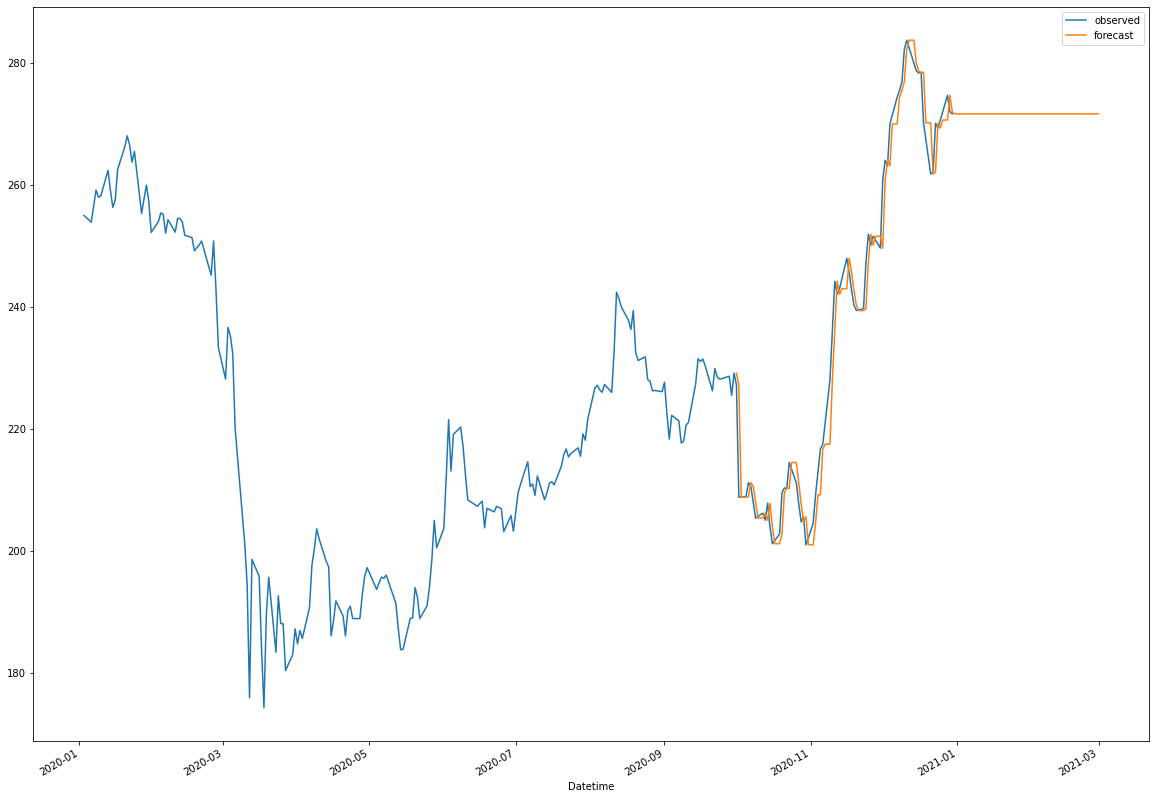

In [503]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
predicted.predicted_mean.plot(ax=ax, label='forecast')

#ax.fill_between(predicted_ci.index, predicted_ci.iloc[:, 0], predicted_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.show()

##### ARIMA Model 2

In [504]:
predicted = fitted2.get_prediction(start=pd.to_datetime("2020-10-01"), end=pd.to_datetime("2021-03-01"), dynamic=False, full_results=True)
predicted_ci = fitted2.conf_int()
#predicted.predicted_mean

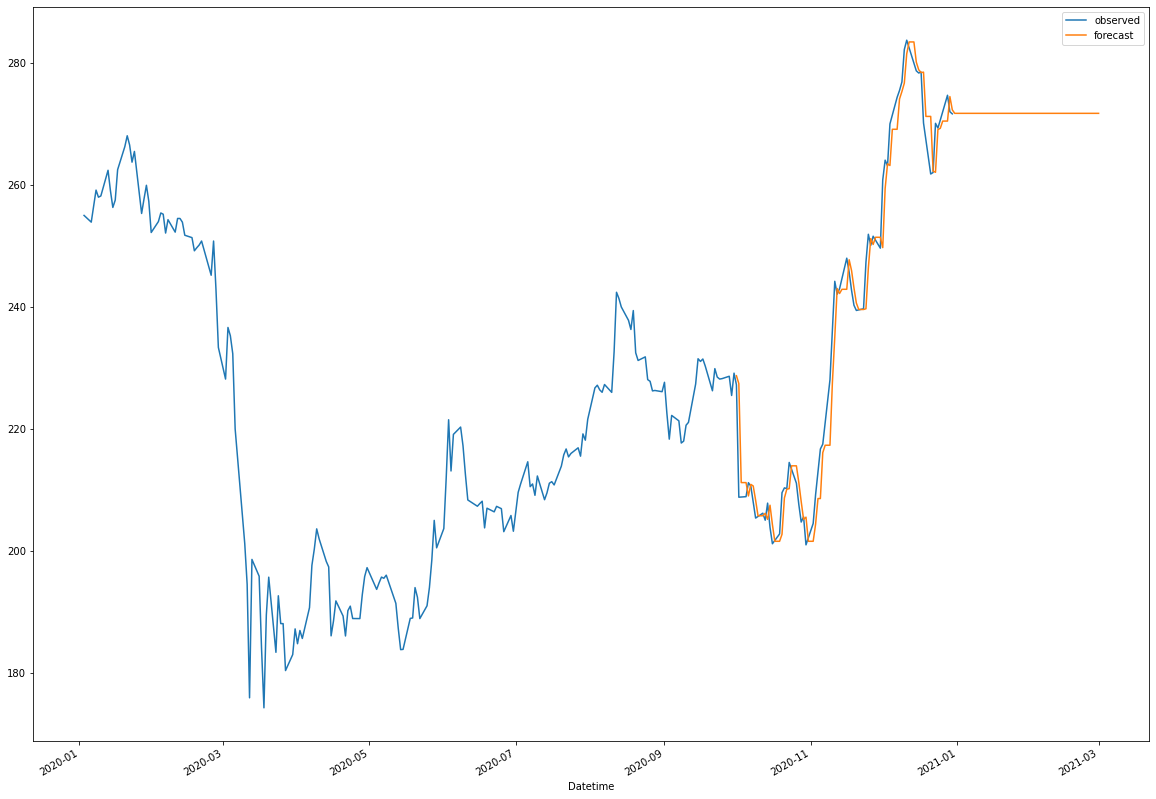

In [505]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
predicted.predicted_mean.plot(ax=ax, label='forecast')

#ax.fill_between(predicted_ci.index, predicted_ci.iloc[:, 0], predicted_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.show()

##### ARIMA Model 3

In [506]:
predicted = fitted3.get_prediction(start=pd.to_datetime("2020-10-01"), end=pd.to_datetime("2021-03-01"), dynamic=False, full_results=True)
predicted_ci = fitted3.conf_int()

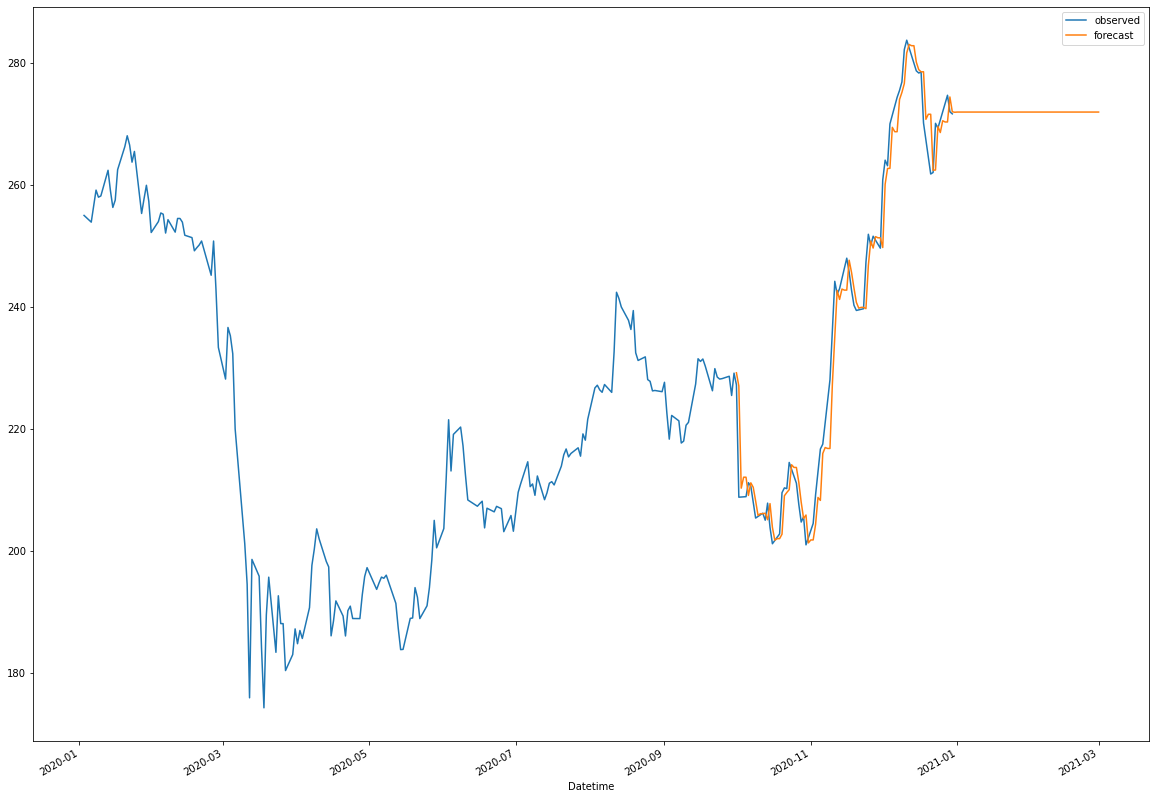

In [507]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
predicted.predicted_mean.plot(ax=ax, label='forecast')

#ax.fill_between(predicted_ci.index, predicted_ci.iloc[:, 0], predicted_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.show()

##### ARIMA Model 4

In [508]:
predicted = fitted4.get_prediction(start=pd.to_datetime("2020-10-01"), end=pd.to_datetime("2021-03-01"), dynamic=False, full_results=True)
predicted_ci = fitted4.conf_int()

In [509]:
predicted.predicted_mean[0:10]

2020-10-01    228.834531
2020-10-02    227.348701
2020-10-03    210.982599
2020-10-04    211.466932
2020-10-05    211.574408
2020-10-06    209.067380
2020-10-07    210.978013
2020-10-08    210.599035
2020-10-09    208.275346
2020-10-10    205.784338
Freq: D, Name: predicted_mean, dtype: float64

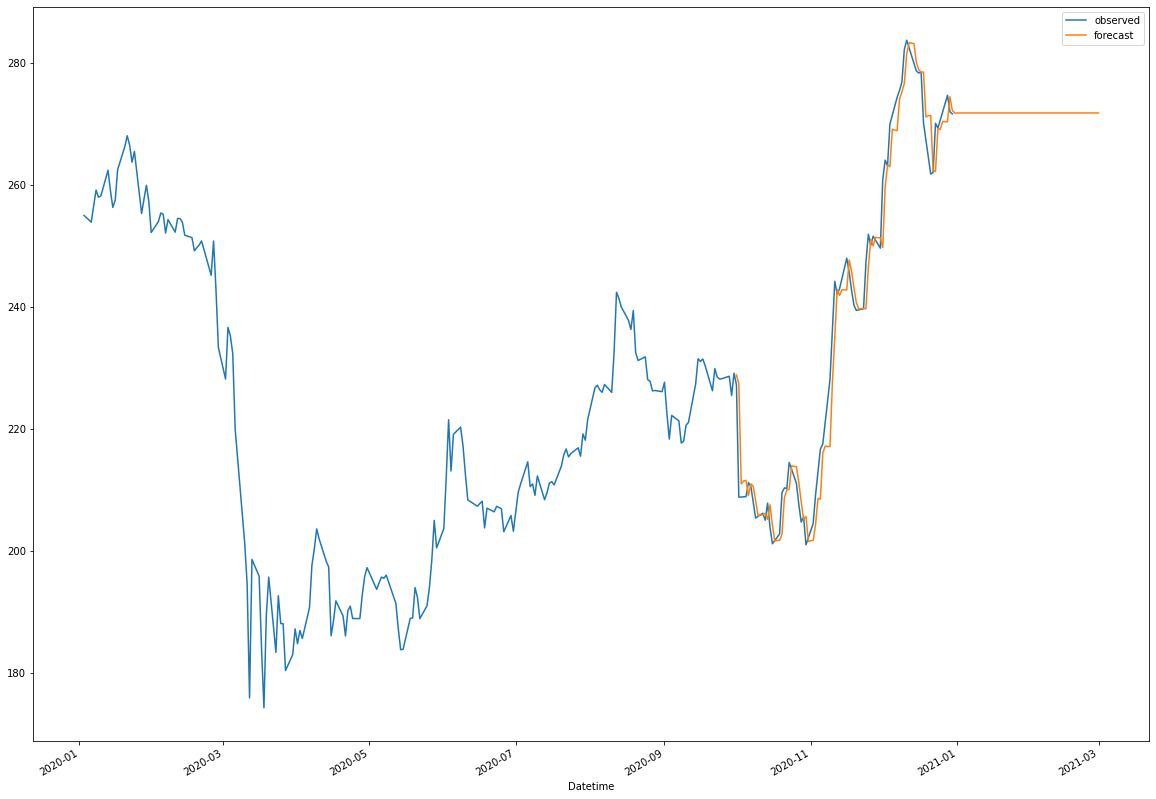

In [510]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
predicted.predicted_mean.plot(ax=ax, label='forecast')

#ax.fill_between(predicted_ci.index, predicted_ci.iloc[:, 0], predicted_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.show()

All of the ARIMA models have predictions that quickly (or immediately) converge to a single value.

##### SES (Simple Exponential Smoothing) Model

In [511]:
fit1 = ses_model.fit()
pred1 = fit1.forecast(9)
pred1

array([271.65000001, 271.65000001, 271.65000001, 271.65000001,
       271.65000001, 271.65000001, 271.65000001, 271.65000001,
       271.65000001])

With smoothing_level = 0.2

In [512]:
fit2 = ses_model.fit(smoothing_level=0.2)
pred2 = fit2.forecast(9)
pred2

array([271.33845345, 271.33845345, 271.33845345, 271.33845345,
       271.33845345, 271.33845345, 271.33845345, 271.33845345,
       271.33845345])

With smoothing_level = 0.5

In [513]:
fit3 = ses_model.fit(smoothing_level=0.5)
pred3 = fit3.forecast(9)
pred3

array([271.85594137, 271.85594137, 271.85594137, 271.85594137,
       271.85594137, 271.85594137, 271.85594137, 271.85594137,
       271.85594137])

Each of these models produce a constant value.

##### HES Model

In [514]:
#pred_holt = fit_holt.forecast(92)
pred_holt = fit_holt.forecast(152)

In [515]:
predictions_holt = pd.Series(pred_holt)
predictions_holt.index = predicted.predicted_mean.index

<AxesSubplot:xlabel='Datetime'>

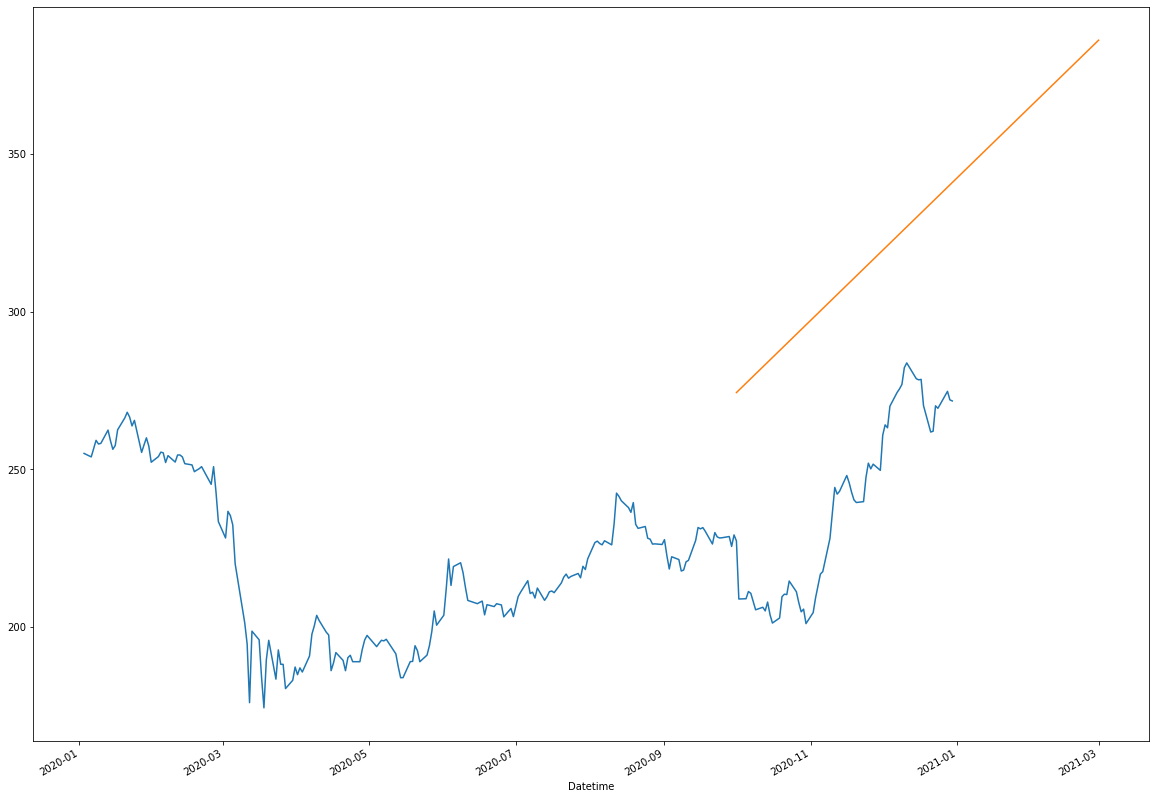

In [516]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
predictions_holt.plot(ax=ax, label='forecast')

##### Simple Moving Average Model

In [517]:
y_hat_sma = sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price.copy()
ma_window = 90 # months
y_hat_sma['Price'] = y_hat_sma.rolling(ma_window).mean()

<AxesSubplot:xlabel='Datetime'>

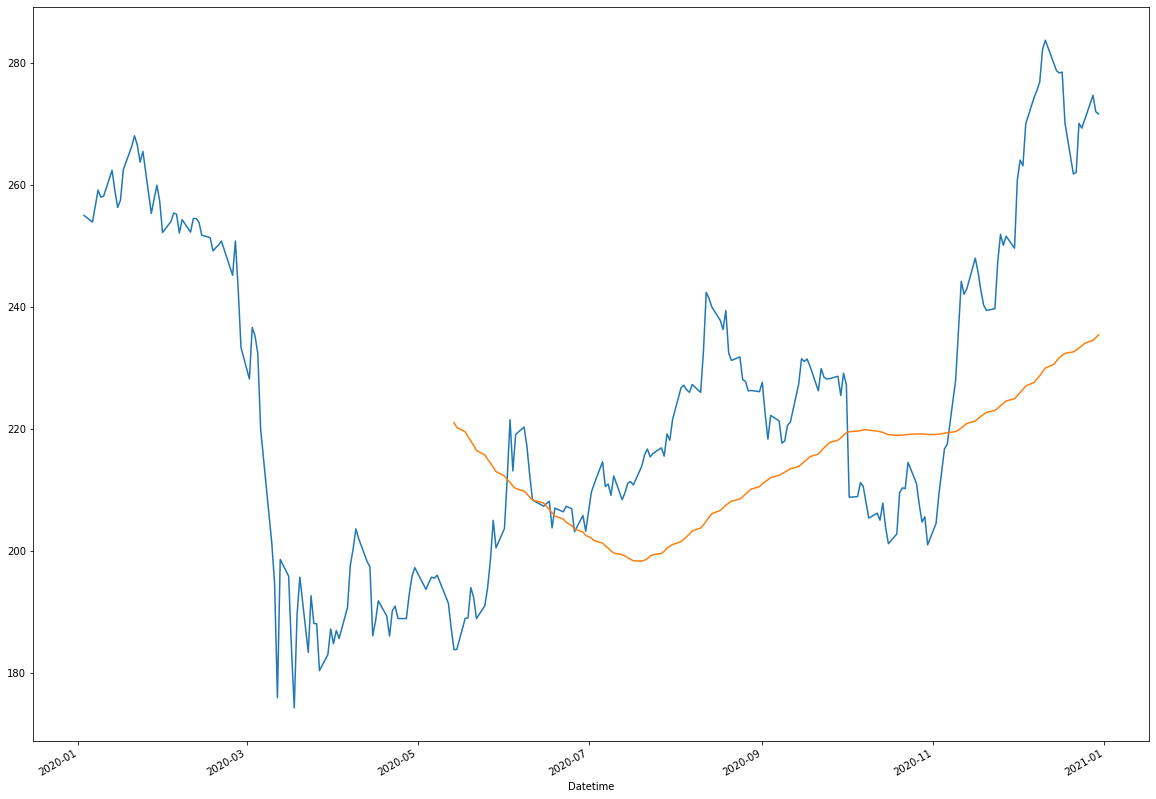

In [518]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
y_hat_sma.Price.plot(ax=ax, label='forecast')

### Forecast Future Unknown Data (2021 data)

Lets use the forecast from the Simple Average Moving Model.

In [519]:
y_hat_sma = sheet1.Price.copy()
ma_window = 12
y_hat_sma['Price'] = y_hat_sma.rolling(ma_window).mean()

<AxesSubplot:xlabel='Datetime'>

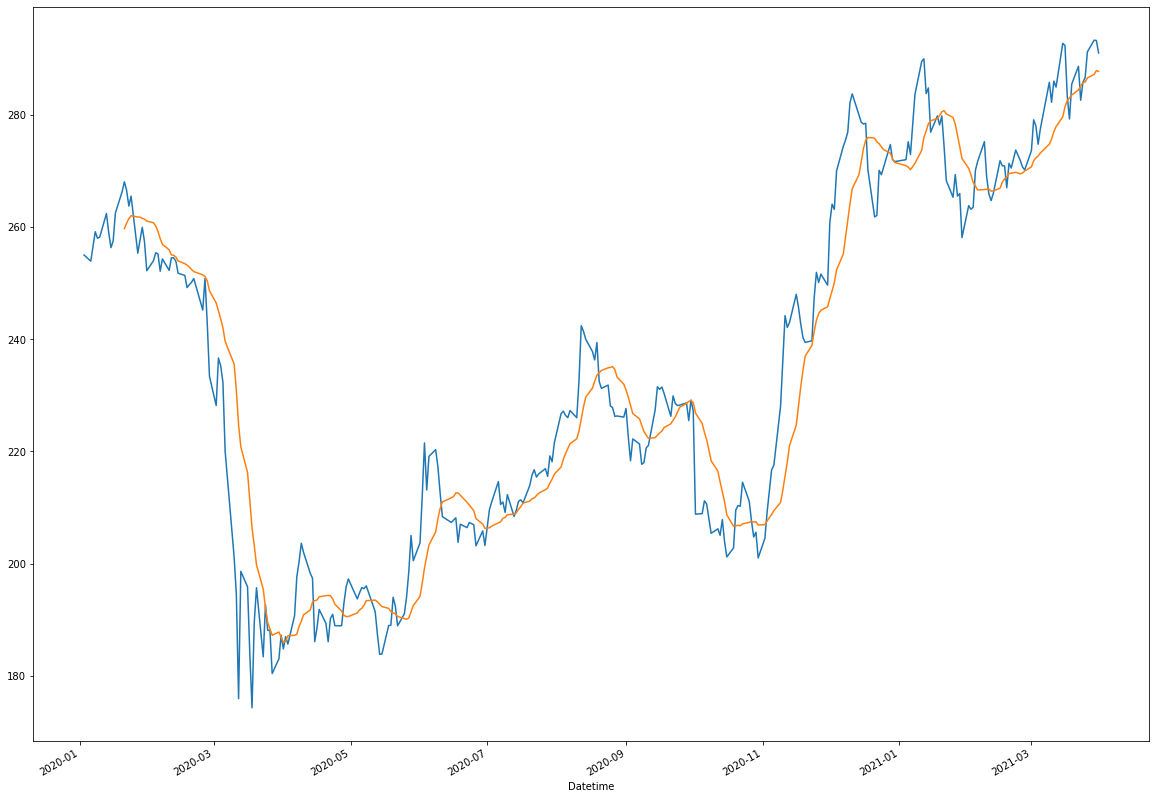

In [520]:
ax = (sheet1.Price).plot(label='observed', figsize=(20, 15))
y_hat_sma.Price.plot(ax=ax, label='forecast')

Lets add a column for the predicted price and the decision (to buy, sell or hold).

In [521]:
sheet1["Predicted Price"] = y_hat_sma.Price
sheet1["Decision"] = ""

We will make decisions according to the following rules:
- If Predicted Price tomorrow > Price today => BUY
- If Predicted Price tomorrow > Price today AND Decision yesterday == BUY => HOLD
- If Predicted Price tomorrow < Price today => SELL

In [522]:
def make_decision(price_today, price_tomorrow, decision_yesterday):
    if float(price_tomorrow) > float(price_today):
        if "BUY" in decision_yesterday:
            return "HOLD"
        return "BUY"
    return "SELL"

Lets mark whether we should buy or sell on each day.

In [523]:
sheet1_predictions = sheet1[sheet1["Datetime"] > "2020-12-31"]

for i in range(len(sheet1_predictions.index)-1):
    # Compare today's price with yesterday's predicted price
    price_today = sheet1_predictions.iloc[i]["Price"]
    price_tomorrow = sheet1_predictions.iloc[i+1]["Predicted Price"]
    decision_yesterday = sheet1_predictions.iloc[i-1]["Decision"]

    # Make decision
    decision = make_decision(price_today, price_tomorrow, decision_yesterday)
    sheet1_predictions.at[sheet1_predictions.iloc[i].Datetime, "Decision"] = str(decision)

In [524]:
sheet1_predictions.head(15)

,Date,Price,Open,High,Low,Vol.,Change %,Datetime,Predicted Price,Decision
Datetime,,,,,,,,,,
2021-01-04,2021-01-04 00:00:00,272.0,274.67,276.6,270.61,48.92,0.0013,2021-01-04,270.937500,SELL
2021-01-05,2021-01-05 00:00:00,275.2,272.69,275.7,270.28,45.58,0.0118,2021-01-05,270.675000,SELL
2021-01-06,2021-01-06 00:00:00,272.93,275.94,275.94,271.62,40.95,-0.0082,2021-01-06,270.210833,SELL
2021-01-08,2021-01-08 00:00:00,283.64,275.11,283.99,275.11,88.93,0.0392,2021-01-08,271.334167,SELL
2021-01-11,2021-01-11 00:00:00,289.49,282.86,292.95,279.48,112.35,0.0206,2021-01-11,273.642500,SELL
2021-01-12,2021-01-12 00:00:00,289.99,290.88,296.07,286.7,78.96,0.0017,2021-01-12,275.971667,SELL
2021-01-13,2021-01-13 00:00:00,283.78,291.01,292.46,283.1,67.56,-0.0214,2021-01-13,277.111667,SELL
2021-01-14,2021-01-14 00:00:00,284.79,284.0,286.9,279.06,74.67,0.0036,2021-01-14,278.400833,SELL
2021-01-15,2021-01-15 00:00:00,276.9,282.55,286.16,276.0,73.77,-0.0277,2021-01-15,278.922500,BUY


In [525]:
# Use volume to calculate profit?


### Apply AUTO ARIMA to remaining data sheets

Lets first plot each dataset (and apply any necessary preprocessing)

In [550]:
sheets = []

for key in df.keys():
    sheet = df[key]
    
    # Drop the last row
    sheet = sheet.iloc[:-1,:] 

    # Convert dates to DateTime
    sheet["Datetime"] = pd.to_datetime(sheet["Date"],format='%Y-%m-%d %H:%M:%S') 

    # Set Datetime as the index
    sheet = sheet.set_index(pd.DatetimeIndex(sheet["Datetime"])).sort_index()

    sheets.append(sheet)

    fig = px.line(sheet, x='Datetime', y="Price")
    fig.show()

/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_76149/2458788776.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_76149/2458788776.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_76149/2458788776.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_76149/2458788776.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_76149/2458788776.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_76149/2458788776.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_76149/2458788776.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_76149/2458788776.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1117.175, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1119.022, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1119.000, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1115.325, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1121.174, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.150 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  186
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -556.663
Date:                Tue, 22 Nov 2022   AIC                           1115.325
Time:                        14:35:21   BIC                           1118.545
Sample:                             0   HQIC                          1116.630
                                - 186                                       

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



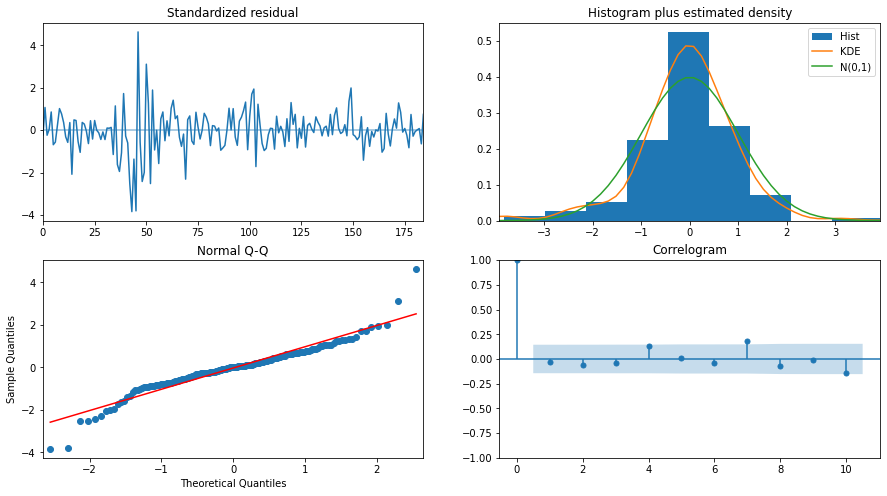

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=187.983, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=189.952, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=189.948, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=187.094, Time=0.01 sec


/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=191.907, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.278 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  187
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -92.547
Date:                Tue, 22 Nov 2022   AIC                            187.094
Time:                        14:35:22   BIC                            190.319
Sample:                             0   HQIC                           188.401
                                - 187                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1584      0.013     12.149      0.000       0.133  

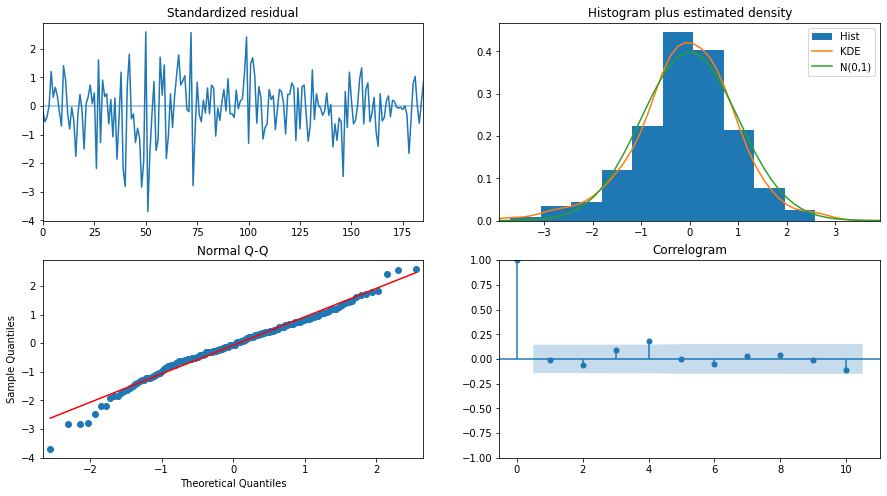

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-334.014, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-343.802, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-343.249, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-334.381, Time=0.03 sec


/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-341.959, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-341.904, Time=0.10 sec


/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packa

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-340.167, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-344.736, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-342.846, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-342.810, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-344.033, Time=0.03 sec


/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-340.970, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.925 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 174.368
Date:                Tue, 22 Nov 2022   AIC                           -344.736
Time:                        14:35:23   BIC                           -338.373
Sample:                             0   HQIC                          -342.155
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2731      0.057      4.796      0.000       0.161 

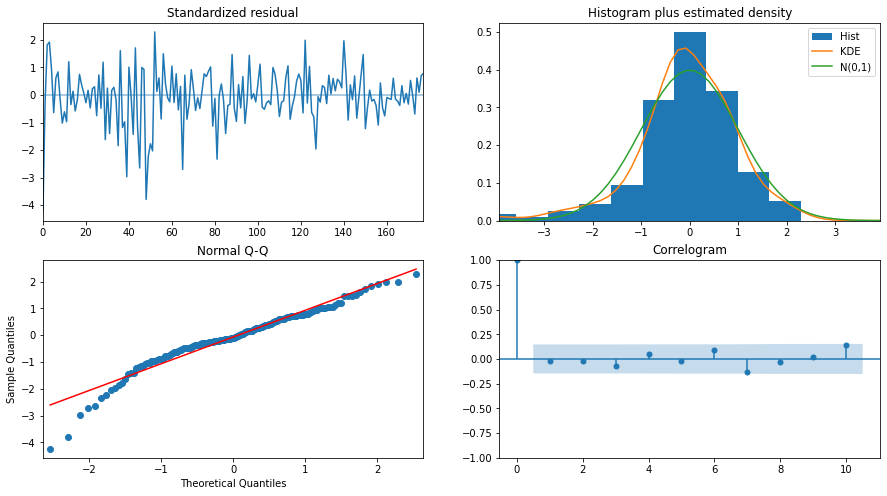

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=245.983, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=246.783, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=247.020, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=244.000, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=249.403, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.193 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  188
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -121.000
Date:                Tue, 22 Nov 2022   AIC                            244.000
Time:                        14:35:24   BIC                            247.231
Sample:                             0   HQIC                           245.310
                                - 188                                         
Co

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



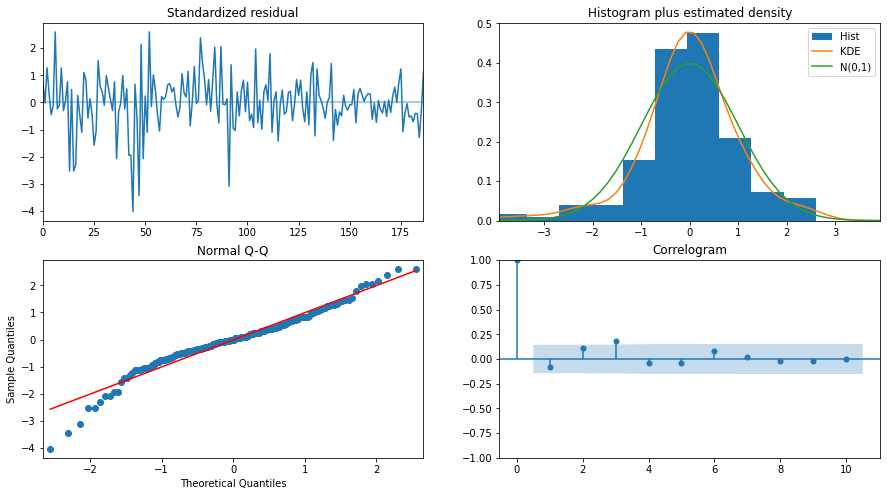

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=731.062, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=731.182, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=730.932, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=729.283, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=731.422, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.191 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  182
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -363.641
Date:                Tue, 22 Nov 2022   AIC                            729.283
Time:                        14:35:24   BIC                            732.481
Sample:                             0   HQIC                           730.580
                                - 182                                         
Co

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



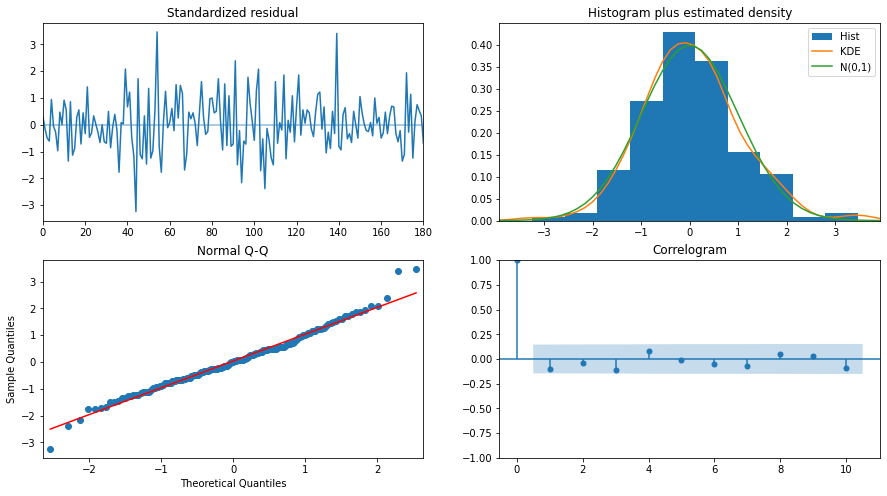

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2382.161, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2382.796, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2383.093, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2381.308, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2382.866, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.200 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  182
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1189.654
Date:                Tue, 22 Nov 2022   AIC                           2381.308
Time:                        14:35:25   BIC                           2384.506
Sample:                             0   HQIC                          2382.604
                                - 182                                       

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



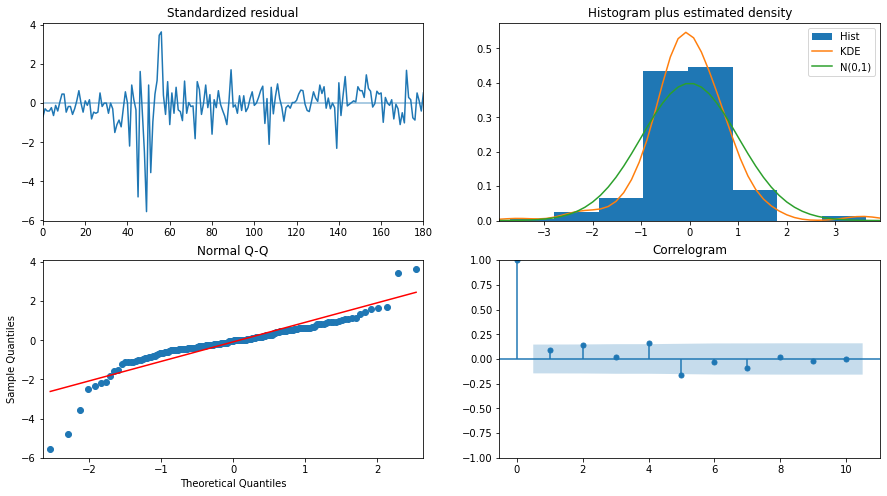

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2968.169, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2969.801, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2969.828, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2966.172, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2971.763, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.128 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  188
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1482.086
Date:                Tue, 22 Nov 2022   AIC                           2966.172
Time:                        14:35:25   BIC                           2969.404
Sample:                             0   HQIC                          2967.482
                                - 188                                       

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



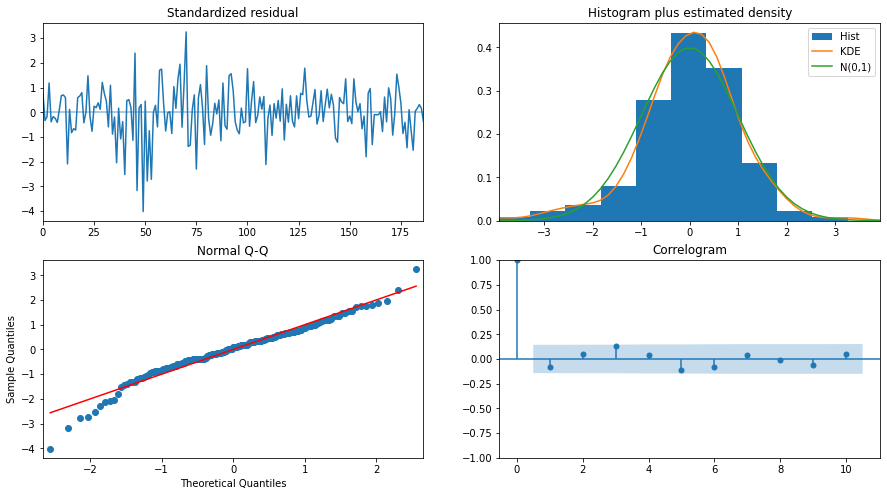

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2727.630, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2729.123, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2729.238, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2725.657, Time=0.02 sec


/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2729.182, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.345 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  202
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1361.828
Date:                Tue, 22 Nov 2022   AIC                           2725.657
Time:                        14:35:26   BIC                           2728.960
Sample:                             0   HQIC                          2726.993
                                - 202                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.492e+04   1664.686     26.985      0.000    4.17e+04 

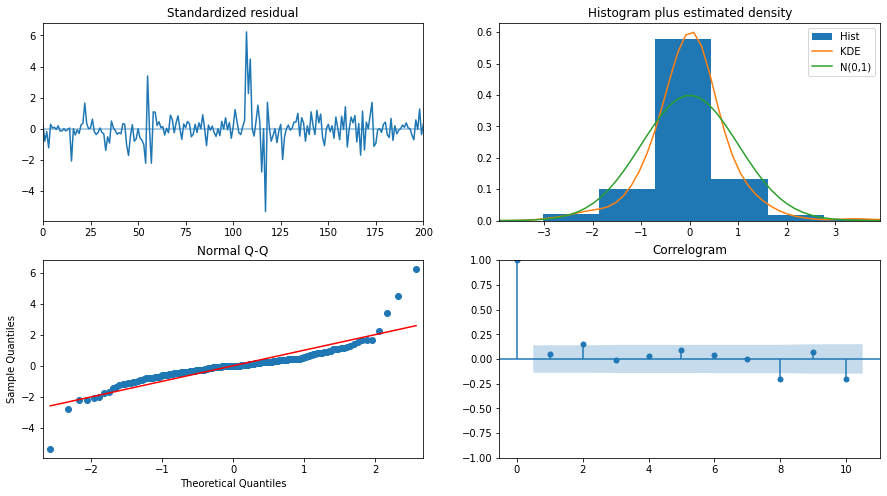

In [552]:
for sheet in sheets:
    # Set training data to be all data before October 2020
    train_data = sheet[sheet["Datetime"] < datetime.strptime("2020-10-01", "%Y-%m-%d")]
    
    # Use Auto ARIMA to find the best p, d, and q values
    model_autoARIMA = auto_arima(train_data.Price, start_p=0, start_q=0,
                        test='adf',       # use adftest to find optimal 'd'
                        max_p=5, max_q=5, # maximum p and q
                        m=1,              # frequency of series
                        d=None,           # let model determine 'd'
                        seasonal=False,   # No Seasonality
                        start_P=0, 
                        D=0, 
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)
    print(model_autoARIMA.summary())
    model_autoARIMA.plot_diagnostics(figsize=(15,8))
    plt.show()

### Summary